# FrozenLake Q-Learning 
## Integrantes:
- Azul Villanueva
- Christopher Charaf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from time import sleep
from IPython.display import clear_output

## Entorno Personalizado (5x5)

In [2]:
class FrozenLakeCustomEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.size = 5
        self.action_space = spaces.Discrete(4)  # 0: izquierda, 1: abajo, 2: derecha, 3: arriba
        self.observation_space = spaces.Discrete(self.size * self.size)
        
        self.map = np.array([
            ['S', 'F', 'F', 'F', 'F'],
            ['F', 'F', 'H', 'F', 'F'],
            ['F', 'H', 'F', 'H', 'F'],
            ['F', 'F', 'F', 'F', 'F'],
            ['H', 'F', 'H', 'F', 'G']
        ])
        
        self.start_pos = (0, 0)
        self.goal_pos = (4, 4)
        self.hole_pos = {(1, 2), (2, 1), (2, 3), (4, 0), (4, 2)}
        self.state = self.start_pos

    def _to_state_index(self, pos):
        return pos[0] * self.size + pos[1]

    def _from_state_index(self, index):
        return (index // self.size, index % self.size)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.start_pos
        return self._to_state_index(self.state), {}

    def step(self, action):
        row, col = self.state
        new_row, new_col = row, col
        if action == 0: new_col = max(col - 1, 0)
        elif action == 1: new_row = min(row + 1, self.size - 1)
        elif action == 2: new_col = min(col + 1, self.size - 1)
        elif action == 3: new_row = max(row - 1, 0)
        
        self.state = (new_row, new_col)
        if self.state in self.hole_pos:
            return self._to_state_index(self.state), -1.0, True, False, {}
        elif self.state == self.goal_pos:
            return self._to_state_index(self.state), 1.0, True, False, {}
        else:
            return self._to_state_index(self.state), -0.01, False, False, {}

    def render(self, mode='human', delay=0.3):
        grid = self.map.copy()
        r, c = self.state
        grid[r, c] = 'A'
        clear_output(wait=True)
        print("Estado actual:")
        print("\n".join([" ".join(row) for row in grid]))
        print(f"Posición: ({r}, {c})")
        sleep(delay)


## Entrenamiento Optimizado

In [3]:
env = FrozenLakeCustomEnv()
n_states = env.observation_space.n
n_actions = env.action_space.n
q_table = np.zeros((n_states, n_actions))

alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.998
n_episodes = 5000

rewards = []
steps_list = []
successes = []

for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])
        
        next_state, reward, done, _, _ = env.step(action)
        best_next = np.max(q_table[next_state])
        q_table[state, action] += alpha * (reward + gamma * best_next - q_table[state, action])
        state = next_state
        total_reward += reward
        steps += 1

    rewards.append(total_reward)
    steps_list.append(steps)
    successes.append(1 if reward == 1.0 else 0)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    if episode % 500 == 0:
        print(f"Episodio {episode}: Recompensa promedio (últimos 100) = {np.mean(rewards[-100:]):.2f}")

Episodio 0: Recompensa promedio (últimos 100) = -1.12
Episodio 500: Recompensa promedio (últimos 100) = -0.15
Episodio 1000: Recompensa promedio (últimos 100) = 0.52
Episodio 1500: Recompensa promedio (últimos 100) = 0.77
Episodio 2000: Recompensa promedio (últimos 100) = 0.91
Episodio 2500: Recompensa promedio (últimos 100) = 0.89
Episodio 3000: Recompensa promedio (últimos 100) = 0.91
Episodio 3500: Recompensa promedio (últimos 100) = 0.93
Episodio 4000: Recompensa promedio (últimos 100) = 0.91
Episodio 4500: Recompensa promedio (últimos 100) = 0.89


## Análisis de Resultados

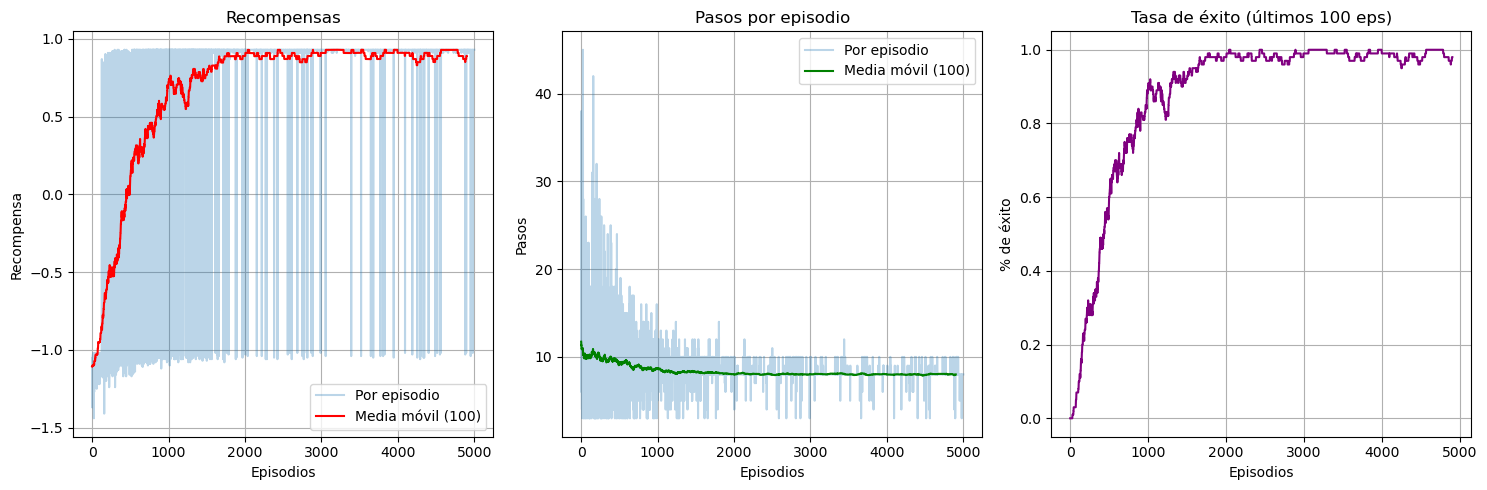

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(rewards, alpha=0.3, label='Por episodio')
plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), 'r', label='Media móvil (100)')
plt.title("Recompensas")
plt.xlabel("Episodios")
plt.ylabel("Recompensa")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(steps_list, alpha=0.3, label='Por episodio')
plt.plot(np.convolve(steps_list, np.ones(100)/100, mode='valid'), 'g', label='Media móvil (100)')
plt.title("Pasos por episodio")
plt.xlabel("Episodios")
plt.ylabel("Pasos")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
success_rate = np.convolve(successes, np.ones(100)/100, mode='valid')
plt.plot(success_rate, 'purple')
plt.title("Tasa de éxito (últimos 100 eps)")
plt.xlabel("Episodios")
plt.ylabel("% de éxito")
plt.grid()
plt.tight_layout()
plt.show()

## Visualización de la Política

In [5]:
def print_policy(q_table, env):
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    print("Política óptima aprendida:")
    for i in range(env.size):
        row = []
        for j in range(env.size):
            pos = (i, j)
            if pos in env.hole_pos:
                row.append('H')
            elif pos == env.goal_pos:
                row.append('G')
            else:
                state_idx = env._to_state_index(pos)
                best_action = np.argmax(q_table[state_idx])
                row.append(action_symbols[best_action])
        print(" ".join(row))
    print("\nValores Q máximos:")
    for i in range(env.size):
        row = []
        for j in range(env.size):
            state_idx = env._to_state_index((i, j))
            max_q = np.max(q_table[state_idx])
            row.append(f"{max_q:.2f}")
        print(" ".join(row))

print_policy(q_table, env)

Política óptima aprendida:
↓ ← → ↓ ↓
↓ ← H → ↓
↓ H ↓ H ↓
→ → → → ↓
H ↑ H → G

Valores Q máximos:
0.86 0.85 0.03 0.12 0.32
0.88 0.86 0.00 0.36 0.82
0.90 0.00 0.93 0.00 0.98
0.92 0.94 0.96 0.98 1.00
0.00 0.92 0.00 1.00 0.00


## Demostración

In [11]:
def demo_agent(env, q_table, max_steps=50):
    state, _ = env.reset()
    done = False
    steps = 0
    print("Demostración del agente entrenado:\n")
    env.render()
    while not done and steps < max_steps:
        action = np.argmax(q_table[state])
        state, reward, done, _, _ = env.step(action)
        env.render()
        steps += 1
    if done and reward > 0:
        print("\n¡Éxito! El agente alcanzó la meta en", steps, "pasos.")
    elif done:
        print("\nEl agente cayó en un hoyo.")
    else:
        print("\nEl agente no alcanzó la meta en el límite de pasos.")

demo_agent(env, q_table)

Estado actual:
S F F F F
F F H F F
F H F H F
F F F F F
H F H F A
Posición: (4, 4)

¡Éxito! El agente alcanzó la meta en 8 pasos.
